<img align="left" src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Assets&ArchHeader.jpeg?raw=true">

# IBM Cloud Pak for Data Version 4.0.2 - Data Virtualization Performance Hands-on Lab

## Introduction
Welcome to the IBM Cloud Pak for Data Multi-Cloud Virtualization Caching Hands-on Lab. 

In this lab you analyze the performance of Data Virtualization using a variety of caching techniques.

This hands-on lab uses live databases, were data is “virtually” available through the IBM Cloud Pak for Data Virtualization Service. It is an advanced Data Virtualization topic and uses the administrator userid, which is required to manage cached data. 

### Where to find this sample online
You can find a copy of this notebook on GITHUB at https://github.com/Db2-DTE-POC/CPDDVHOL4.

## The Data and the Business Problem
This hands-on lab analyzes details records of detailed flight time data for all the domestic flights in the United States from 2009 to 2015. The total number of flight time data is almost 43 millions rows of data. There are additional dimension tables to support this large fact table. The table used to supplement the ONTIME fact table is the AIRCRAFT dimension table that includes details on each aircraft with entries in the ONTIME table. 

From the almost 43 million flights, the lab analyzes flights between New Jersy and California for the Boeing 737. 

## In this lab you learn how to:

* Navigate to the Cloud Pak for Data Data Virtualization Cache Management user interface
* Use the Cloud Pak for Data RESTful API to control the existing ONTIME database caches
* Explore Views created to capture and "reduce" the working dataset of ONTIME fligth records
* Understand how caches were created based on those views
* Compare performance between with and without caches
* Compare performance using complete and targetted caches
* Use the RESTful API to expore and refresh caches

## Getting Started

## Using Jupyter notebooks
You are now officially using a Jupyter notebook! If this is your first time using a Jupyter notebook you might want to go through the Db2 Data Management Console Hands on Lab at www.ibm.biz/DMCDemosPOT. It includes an introduction to using Jupyter notebooks with the Db2 family. The introduction shows you some of the basics of using a notebook, including how to create the cells, run code, and save files for future use. 

Jupyter notebooks are based on IPython which started in development in the 2006/7 timeframe. The existing Python interpreter was limited in functionality and work was started to create a richer development environment. By 2011 the development efforts resulted in IPython being released (http://blog.fperez.org/2012/01/ipython-notebook-historical.html).

Jupyter notebooks were a spinoff (2014) from the original IPython project. IPython continues to be the kernel that Jupyter runs on, but the notebooks are now a project on their own.

Jupyter notebooks run in a browser and communicate to the backend IPython server which renders this content. These notebooks are used extensively by data scientists and anyone wanting to document, plot, and execute their code in an interactive environment. The beauty of Jupyter notebooks is that you document what you do as you go along.

## Connecting to IBM Cloud Pak for Data
For this lab you use the admin userid.
* ID: admin
* PASSWORD: CP4DDataFabric

If you have this notebook open, you should have already signed in using the admin userid. 
1. To check your userid, click the icon at the very top right of the webpage. It will look something like this:

    <img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/11.06.10 EngineerUserIcon.png?raw=true">

2. Click **Profile and settings**
3. Click **Permissions** and review the user permissions for this user


### Exploring the ONTIME dataset
Let's start by looking at the the ONTIME dataset that has already been virtualized. 

You should now have this Hands-on Lab notebook on the left side of your screen and the Cloud Pak for Data Console on the right side of your screen. In the Cloud Pak for Data Console:

1. Click the three bar (hamburger) menu at the top left of the console
2. Click on the Data menu item if is not already expanded
3. Right click **Data Virtualization** and select **Open in New Window**
4. Arrange your windows so that notebook is on one side of your screen and the Cloud Pak Data Virtualization Console is on the other side. This makes it easier to follow the instructions without having to jump back and forth between the notebook and the console.

    <img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/SidebySide.png?raw=true">
    
5. If you don't see the page above, click the **Data Virtualization** menu in the Cloud Pak for Data Console and select **Data Sources**.
4. Click **Constellation View**. A spider diagram of the connected data sources opens. 

    <img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/ConstellationView.png?raw=true">

    This displays the Data Source Graph with numerous active data sources. The ONTIME dataset is sourced from:
    * 5 Db2 Databases hosted on premises and accessed throught a remote connector. Each database contains one year of ONTIME flight data. 
    * Db2 Warehouse Database on Cloud Pak for Data
    * Netezza Performance Server on the Public Cloud
    * EDB Postgres Database on Premises
    * Virtualized CSV files on Premises

There five ONTIME Db2 Databases have been combined ("folded") into a single virtual table called ONTIME.ONTIME1115. It includes flight records for the years 2011 to 2015. One year from each database. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/RemoteConnector.png?raw=true">

The Db2 Warehouse on Cloud Pak for Data includes all the years of flight records from 2009 to 2015. However the view ONTIME.ONTIME0910 retrieves only the years 2009 and 2010 from the single warehouse database. Notice the predicate that limits the results to the years 2009 and 2010.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/ONTIME0910VIEW.png?raw=true">

The ONTIME.ONTIME view combines the data from the ONTIME.ONTIME1115 and the ONTIME.ONTIME0910 views. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/ONTIMEONTIMEVIEW.png?raw=true">

It is a union between the rows from ONTIME1115 and ONTIME0910. 

### What is Caching
Data Virtualization can make tables on remote data sources look, act and feel like data in a local table. The Data Virtualization engine acts as a single database that contains data from remote tables on remote data source. However, the data is not stored in the Data Virtualization Database. When you submit a query, it is analyzed by the Data Virtualization optimizer. The statement is rewritten and decomposed into parts or branches and data is retreived from each remote data source as required. Each time you run a query, you receive the latest data from the remote data servers. 

If your remote data servers are responsive, this may perform very fast, even when you are joining data from different sources together in the data virtualizaton engine. Data Virtualization will minimize the volume of data that needs to be retrieved from each remote source to optimize performance. It pushes down predicates, for example WHERE AIRCRAFT='737' from the original query to the remote data server.

If you have to retrieve large data sets from the remote servers, caching can dramatically improve performanmce and reduce the load on the remote data servers. 

When you create a cache by defining a query against the data virtualiztion server. The results of that query (the rows returned) are stored in a fast local storage system. The next time you run that query, the data virtualization engine uses the locally cached data and avoids fetching data from the remote data servers. The rows that are returned are accurate to the time that the cache was created. You can refresh the data in the cache whenever you need to or set a refresh interval and it is automnatically refreshed.

The magic of caching is that a statement doesn't have to be exactly like your cache definition for the cache to be used. The data virtualizaiton optimizer looks for caches that contain the required data and uses them when possible.

This hands-on lab explores the difference between no using a cache, using a cache and using caches focuses on targetted data sets to optimize performance and minimize cache size and refresh requirements.

You can learn more about Data Virtualization caching at: https://www.ibm.com/docs/en/cloud-paks/cp-data/4.0?topic=data-managing-caches-queries

# Exploring the Data Virtualization User Interface
1. Select Cache management from the Data Virtualization drop down menu.
The Cache management page is only available to Data Virtualizaton admninistrators. It contain:
* A summary of the local storage used and available
* I histogram showing the effectiveness of your existing caches
* A list of the currently active data caches, including:
    * The name of the cache
    * The size of the cache
    * The number of rows in the cache, also know as its cardinality
    * When the cache was last used and how many times it has been used

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/CacheManagement.png?raw=true">

To see a list of the actions available on each cache, click the elipsis menu to the right side of a cache in the list of currently available caches. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/CacheMenu.png?raw=true">

To see the query that defines a cache select **View cache details**. In this example the cache was defined by selecting all the columns from a view, ONTIME.ONTIME1115 that is defined on a set of virtualized tables.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/CacheDetail.png?raw=true">

You can also see a list of the queries that ran on the system. Click the **Queries** tab in the upper-left of the page. Then click the carrot symbol at the left side of a single query to see the full query statement.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/Queries.png?raw=true">

In this case the query has run with and without a cache. Performance with the cache is faster than without. To see more details, click **View Details** in the lower right.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/FullQuery.png?raw=true">

This includes a history of query execution times. You may have to adjust the timeframe to see previous executions. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/QueryDetail.png?raw=true">

# Running Scripted Performance Benchmarks with and Without Caching

The IBM Cloud Pak for Data Console is only one way you can interact with the Virtualization service. IBM Cloud Pak for Data is built on a set of microservices that communicate with each other and the Console user interface using RESTful APIs. You can use these services to automate anything you can do throught the user interface.

This Jupyter Notebook contains examples of how to use the Open APIs to retrieve information from the virtualization service, how to run SQL statements directly against the service through REST and how to provide authoritization to objects. This provides a way write your own script to automate the setup and configuration of the virtualization service. 

### Load the REST API Class
The next part of the lab relies on a set of base classes to help you interact with the RESTful Services API for IBM Cloud Pak for Data Virtualization. You can access this library on GITHUB. The commands below download the library and run them as part of this notebook.
<pre>
&#37;run CPDDVRestClassV402.ipynb
</pre>
The cell below loads the RESTful Service Classes and methods directly from GITHUB. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook. You can click on the following like to browse the RESTful Services class file: https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/RESTfulEndpointServiceClass402.ipynb. You are free to download and reuse this sample for your own applications.

1. Click the cell below
2. Click **Run**

In [1]:
!wget -O CPDDVRestClassV402.ipynb https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVHOL4/main/CPDDVRestAPIClass402.ipynb
%run CPDDVRestClassV402.ipynb

--2021-12-08 17:40:15--  https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVHOL4/main/CPDDVRestAPIClass402.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15024 (15K) [text/plain]
Saving to: ‘CPDDVRestClassV402.ipynb’

CPDDVRestClassV402. 100%[===================>]  14.67K  --.-KB/s    in 0s      

2021-12-08 17:40:15 (58.1 MB/s) - ‘CPDDVRestClassV402.ipynb’ saved [15024/15024]



### Connect to the DV RESTful Service
To connect to the Data Virtualization service you need to provide the URL, the service name (v1) and profile the console user name and password. This is the samne as logging into the Cloud Pak for Data console but through a Python notebook instead of the user interface on your browser. Run the next cell. You should see that a connection token is successfully retrieved. 

In [2]:
# Set the service URL to connect from inside the ICPD Cluster
Console  = 'https://cpd-cpd-instance.apps.demo.ibmdte.net:31192'

# Connect to the Db2 Data Management Console service
user     = 'admin'
password = 'CP4DDataFabric'

# Set up the required connection
databaseAPI = DVRESTAPI(Console)
api = '/v1'
databaseAPI.authenticate(api, user, password)
database = Console

Token Retrieved


### Virtualized Tables and Views
This next call retrieves all the virtualized tables and views available to the userid that you use to connect to the service. In this example the whole call is included in the DVRESTAPI class library and returned as a complete Dataframe ready for display or to be used for analysis or administration.

In [ ]:
### Display Virtualized Tables and Views 
display(databaseAPI.getVirtualizedTablesDF())
display(databaseAPI.getVirtualizedViewsDF())

### Get a list of the Data Virtualization Caches
A single call to the DVRESTAPI class returns all the information available about all the caches. 

In [3]:
display(databaseAPI.getCaches())

,name,id,query,owner_id,type,created_timestamp,last_modified_timestamp,last_refresh_timestamp,last_used_timestamp,state,size,cardinality,time_taken_for_refresh,refresh_count,hit_count,refresh_schedule,refresh_schedule_desc,status_msg
0,ONTIME0915,DV202111161222469697,SELECT * FROM ONTIME.ONTIME,ADMIN,U,2021-11-16 12:22:46.969151,2021-11-16 15:54:05.80047,2021-11-16 12:59:22.006647,2021-11-16 15:50:31.796,Disabled,1309298,30238851,0,0,3,,,
1,BOEING737,DV20211110165634403313,SELECT * FROM ONTIME.BOEING737,ADMIN,U,2021-11-10 16:56:34.402815,2021-12-07 16:41:12.825213,2021-11-10 18:30:21.411623,2021-12-03 16:58:05.092,Enabled,56967,4172450,0,0,16,,,The current transaction has been rolled back b...
2,ONTIME737NJCA,DV20211115151427714635,SELECT * FROM ONTIME.ONTIME737NJCA,ADMIN,U,2021-11-15 15:14:27.714001,2021-12-07 16:41:13.48514,2021-11-15 15:33:30.254003,2021-12-03 16:58:10.365,Enabled,554,37621,0,0,24,,,The current transaction has been rolled back b...
6,ONTIME0910,DV20211110144113849337,SELECT * FROM ONTIME.ONTIME0910,ADMIN,U,2021-11-10 14:41:13.848923,2021-12-07 16:35:40.312217,2021-11-10 16:32:41.327378,2021-12-03 16:57:54.857,Enabled,591398,12752436,0,0,26,,,The current transaction has been rolled back b...
7,AIRCRAFT,DV20211115221309388288,SELECT * FROM ONTIME.AIRCRAFT,ADMIN,U,2021-11-15 22:13:09.387651,2021-12-07 16:35:41.780559,2021-12-03 16:36:36.670765,2021-12-03 16:58:05.092,Enabled,106,13101,17913,1,44,,,
10,ONTIME1115,DV20211110144049703423,SELECT * FROM ONTIME.ONTIME1115,ADMIN,U,2021-11-10 14:40:49.702724,2021-12-07 16:35:41.627616,2021-11-10 15:01:13.967413,2021-12-03 16:57:54.857,Enabled,1399806,30190408,0,0,46,,,The current transaction has been rolled back b...


The **getCaches** routine can show just the enabled or disabled caches using a single parameter. You can also easily choose just the columns you want to see by defining the columns using the dataframe returned by the call.

In [ ]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

In [ ]:
df = databaseAPI.getCaches('Disabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

### Running the Ontime Query without a Cache
Now that you have retrieved the list of enabled and disabled caches, lets run a set of queries to retrieve the number of rows in each cache, its cardinality. You can see this through the Cache management interface, but we want to collect the size of each cache to create a graph to compare them. Before we run the queries, let's make sure that all the caches are enabled.

In [4]:
# Enable ONTIME1115
databaseAPI.enableCache('DV20211110144113849337')

409
The requested operation cannot be performed currently : Cannot Enable right now


In [5]:
# Enable ONTIME0910
databaseAPI.enableCache('DV20211110144049703423')

409
The requested operation cannot be performed currently : Cannot Enable right now


In [6]:
# Enable AIRCRAFT
databaseAPI.enableCache('DV20211115221309388288')

409
The requested operation cannot be performed currently : Cannot Enable right now


In [7]:
# Enable BOEING737
databaseAPI.enableCache('DV20211110165634403313')

409
The requested operation cannot be performed currently : Cannot Enable right now


In [8]:
# Enable ONTIME737NJCA
databaseAPI.enableCache('DV20211115151427714635')

409
The requested operation cannot be performed currently : Cannot Enable right now


### Running Statements against the Data Virtualization server
Before we can run queries against Data Virtualization we need to connect to it through the JDBC port. Data Virtualization supports the full SQL and JDBC drivers as Db2. So we can use the Db2 Python Magic library available from GITHUB.

In [9]:
!wget -O db2.ipynb https://raw.githubusercontent.com/Db2-DTE-POC/Db2-Openshift-11.5.4/master/db2.ipynb
%run db2.ipynb
print('db2.ipynb loaded')

--2021-12-08 17:40:35--  https://raw.githubusercontent.com/Db2-DTE-POC/Db2-Openshift-11.5.4/master/db2.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168432 (164K) [text/plain]
Saving to: ‘db2.ipynb’

db2.ipynb           100%[===================>] 164.48K  --.-KB/s    in 0.009s  

2021-12-08 17:40:35 (17.1 MB/s) - ‘db2.ipynb’ saved [168432/168432]

Db2 Extensions Loaded.
db2.ipynb loaded


Connect to the Data Virtualization data server using the admin userid and password.

In [10]:
# Connect to the Data Virtualization Database
database = 'bigsql'
user = 'admin'
password = 'CP4DDataFabric'
host = 'cpd-cpd-instance.apps.demo.ibmdte.net'
port = '31193'

%sql CONNECT TO {database} USER {user} USING {password} HOST {host} PORT {port}

Connection successful.


Run the next six cells to collect the number of rows in each of the following views. Since the cache that was created for each view is enabled, this returns the number of rows in each cache. 

In [11]:
ontime0910count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME0910;

In [12]:
ontime1115count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME1115;

In [13]:
ontime737count = %sql SELECT COUNT(*) FROM ONTIME.BOEING737;

In [14]:
ontimenjca737count = %sql SELECT COUNT(*) FROM ONTIME.ONTIME737NJCA;

In [15]:
aircraftcount = %sql SELECT COUNT(*) FROM ONTIME.AIRCRAFT;

Run the next cells to extract the first value from the DataFrame with the results of each query.

In [16]:
ontime0910 = ontime0910count['1'][0]
ontime1115 = ontime1115count['1'][0]
ontimefull = ontime0910 + ontime1115
ontime737 = ontime737count['1'][0]
ontimenjca737 = ontimenjca737count['1'][0]
aircraft = aircraftcount['1'][0]

Run the next cell to see the number of rows in each view.

In [17]:
print('Aircraft:' + str(aircraft))
print('Number of Domestic Flights in the US')
print('Years 2009 to 2010: ' + str(ontime0910))
print('Years 2011 to 2015: ' + str(ontime1115))
print('Years 2009 to 2015: ' + str(ontimefull))
print('Only 737 from 2009 to 2015: ' + str(ontime737))
print('Only 737 from NJ to CA: ' + str(ontimenjca737))

Aircraft:13101.0
Number of Domestic Flights in the US
Years 2009 to 2010: 12752436.0
Years 2011 to 2015: 30190408.0
Years 2009 to 2015: 42942844.0
Only 737 from 2009 to 2015: 4172450.0
Only 737 from NJ to CA: 37621.0


### Running without any Caches
For the first performance runs without any caches. This is the performance baseline that caches are compared against. Run the next five cells to disable all of the caches. 

In [18]:
# Disable ONTIME0910
databaseAPI.disableCache('DV20211110144113849337')

Cache: DV20211110144113849337 disabled.


In [19]:
# Disable ONTIME1115
databaseAPI.disableCache('DV20211110144049703423')

Cache: DV20211110144049703423 disabled.


In [20]:
# Disable BOEING737
databaseAPI.disableCache('DV20211110165634403313')

Cache: DV20211110165634403313 disabled.


In [21]:
# Disable ONTIME737NJCA
databaseAPI.disableCache('DV20211115151427714635')

Cache: DV20211115151427714635 disabled.


In [22]:
# Disable AIRCRAFT
databaseAPI.disableCache('DV20211115221309388288')

Cache: DV20211115221309388288 disabled.


Run the next cell to confirm that all the caches are disabed

In [23]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp


Now you can run the ontime analysis query. 

**Run the next three cells.** 

The first cell runs the query and returns the first five rows of the result set. The second cell, reruns the query. The second time run results of the time to run the query is captured using the %time and %capture magic Python tags. The third cell collects the results of the second cell for later.

The statement below joins the ONTIME table and the AIRCRAFT table on the Tail Number of each aircraft. It then searches through the almost 44 million flight records to find only the flights for 737 aircraft that flew from New Jersy to California with a Taxi out time of greater than 30 minutes, a total flight distance of over 2000 miles and a departure delay of over 200 minutes. It then orders the results by the highest arrival delay time first. 

These queries typically take about 1 minute and 20 seconds to run each. So while you are waiting for them to complete skip ahead to the next second and lets see how the data virtualization engine is going to retrieve the results.

In [24]:
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

,DAYKEY,YEAR,QUARTERKEY,QUARTER,MONTHKEY,MONTH,DAYOFMONTH,DAYOFWEEK,FLIGHTDATE,UNIQUECARRIER,AIRLINEID,CARRIER,TAILNUM,FLIGHTNUM,ORIGINAIRPORTID,ORIGINAIRPORTSEQID,ORIGINCITYMARKETID,ORIGIN,ORIGINCITYNAME,ORIGINSTATE,ORIGINSTATEFIPS,ORIGINSTATENAME,ORIGINWAC,DESTAIRPORTID,DESTAIRPORTSEQID,DESTCITYMARKETID,DEST,DESTCITYNAME,DESTSTATE,DESTSTATEFIPS,DESTSTATENAME,DESTWAC,CRSDEPTIME,DEPTIME,DEPDELAY,DEPDELAYMINUTES,DEPDEL15,DEPARTUREDELAYGROUPS,DEPTIMEBLK,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,CRSARRTIME,ARRTIME,ARRDELAY,ARRDELAYMINUTES,ARRDEL15,ARRIVALDELAYGROUPS,ARRTIMEBLK,CANCELLED,CANCELLATIONCODE,DIVERTED,CRSELAPSEDTIME,ACTUALELAPSEDTIME,AIRTIME,FLIGHTS,DISTANCE,DISTANCEGROUP,CARRIERDELAY,WEATHERDELAY,NASDELAY,SECURITYDELAY,LATEAIRCRAFTDELAY,FIRSTDEPTIME,TOTALADDGTIME,LONGESTADDGTIME,DIVAIRPORTLANDINGS,DIVREACHEDDEST,DIVACTUALELAPSEDTIME,DIVARRDELAY,DIVDISTANCE,DIV1AIRPORT,DIV1AIRPORTID,DIV1AIRPORTSEQID,DIV1WHEELSON,DIV1TOTALGTIME,DIV1LONGESTGTIME,DIV1WHEELSOFF,DIV1TAILNUM,DIV2AIRPORT,DIV2AIRPORTID,DIV2AIRPORTSEQID,DIV2WHEELSON,DIV2TOTALGTIME,DIV2LONGESTGTIME,DIV2WHEELSOFF,DIV2TAILNUM,DIV3AIRPORT,DIV3AIRPORTID,DIV3AIRPORTSEQID,DIV3WHEELSON,DIV3TOTALGTIME,DIV3LONGESTGTIME,DIV3WHEELSOFF,DIV3TAILNUM,DIV4AIRPORT,DIV4AIRPORTID,DIV4AIRPORTSEQID,DIV4WHEELSON,DIV4TOTALGTIME,DIV4LONGESTGTIME,DIV4WHEELSOFF,DIV4TAILNUM,DIV5AIRPORT,DIV5AIRPORTID,DIV5AIRPORTSEQID,DIV5WHEELSON,DIV5TOTALGTIME,DIV5LONGESTGTIME,DIV5WHEELSOFF,DIV5TAILNUM,UNKNOWNCOL110,NUMROWS,TAIL_NUMBER,MANUFACTURER,MODEL
0,20120809,2012,201203,3,201208,8,9,4,2012-08-09,UA,19977,UA,N16217,1083,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14908,1490803,32575,SNA,"Santa Ana, CA",CA,6,California,91,1823,2215,232,232,1,12,1800-1859,55,2310,NaN,NaN,2133,NaN,NaN,NaN,NaN,NaN,2100-2159,0,None,1,370,NaN,NaN,1,2434,10,NaN,NaN,NaN,NaN,NaN,None,None,None,1,0.0,None,None,36.0,LAX,12892.0,1289203.0,123.0,8.0,8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N16217,Boeing,B737-800PAX
1,20091101,2009,200904,4,200911,11,1,7,2009-11-01,CO,19704,CO,N78506,787,11618,1161801,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14908,1490802,32575,SNA,"Santa Ana, CA",CA,6,California,91,1730,2219,289,289,1,12,1700-1759,31,2250,NaN,NaN,2057,NaN,NaN,NaN,NaN,NaN,2000-2059,0,None,1,387,NaN,NaN,1,2433,10,NaN,NaN,NaN,NaN,NaN,None,None,None,1,0.0,None,None,36.0,LAX,12892.0,1289201.0,117.0,5.0,5.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N78506,Boeing,B737-800PAX
2,20150531,2015,201502,2,201505,5,31,7,2015-05-31,UA,19977,UA,N37470,1670,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,14771,1477102,32457,SFO,"San Francisco, CA",CA,6,California,91,1500,2019,319,319,1,12,1500-1559,77,2136,34.0,6.0,1815,40.0,385.0,385.0,1.0,12.0,1800-1859,0,None,0,375,441.0,358.0,1,2565,11,0.0,314.0,66.0,0.0,5.0,None,None,None,0,NaN,None,None,NaN,,NaN,NaN,NaN,NaN,NaN,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,,None,None,None,None,None,None,,None,1,N37470,Boeing,B737-900ERPAX
3,20120810,2012,201203,3,201208,8,10,5,2012-08-10,UA,19977,UA,N73291,17,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,12892,1289203,32575,LAX,"Los Angeles, CA",CA,6,California,91,1300,1847,347,347,1,12,1300-1359,39,1926,2141.0,31.0,1552,2212.0,380.0,380.0,1.0,12.0,1500-1559,0,None,0,352,385.0,315.0,1,2454,10,347.0,0.0,33.0,0.0,0.0,None,None,None,0,NaN,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,N73291,Boeing,B737-800PAX
4,20150615,2015,201502,2,201506,6,15,1,2015-06-15,UA,19977,UA,N78524,1289,11618,1161802,31703,EWR,"Newark, NJ",NJ,34,New Jersey,21,128

In [25]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

The next cell, prints the results of the previous run and captures the time in the sqldnocachetimer object. Later this value will ber compared to other test runs. 

In [26]:
sqldvnocachetimer = Timer()
sqldvnocachetimer.timeTotal()

CPU times: user 16.4 ms, sys: 414 us, total: 16.9 ms
Wall time: 1min 26s

Time: 86 s
Total Time: 86 s


### Using Visual Explain to see your query runs
The Data Virtualization SQL Editor includes a very useful tool called Visual Explain that lets you see exactly how the Data Virtualization engine retrieves your results. Let's open the SQL editor and load a script that contains a set of queries we that we can analyze.
1. Using the Cloud Pak for Data user interface, select **Run SQL** from the Data Virtualization Drop down menu.
2. Click **AddNewScript**

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/AddNewScript.png?raw=true">

3. Enter **Caching** in the script search field
4. click the carrot symbol to the left of the **ONTIME Caching** script to see the whole script
5. Click the folder with a plus sign icon to the right of the script. The opens in the SQL Editor.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/AddNewScriptSelectONTIME.png?raw=true">

6. We just want to analyze the ONTIME.ONTIME script, which is the second from the top. Select the script.

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/EditorSelectONTIMEONTIME.png?raw=true">

7. Click the Visual Explain icon

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/ExplainTheStatement.png?raw=true">

8. After an analysis of the statement, a visual description of how the result set is retrieved appears:

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/VEONTIMENoCache.png?raw=true">

9. Each step of the processing occurs in parallel from the bottom of the graph to the top. Double click on any tile to see additional details of that step. 

20. Click the tile at the bottom of the graph, second from the right. This part of the graph shows details of how data is retrieved from the ONTIME 2011 to 2015 set of databases. The Data Virtualization optimizer rewrites the query and writes new statements for each data source. Predicates are included to reduce the data set retrieved from the remote data source. In this case only flights from New Jersey to California are include and only flight that fight the required flight time profile. 

The statement is sent to the remote connector that joins the ONTIME11 to ONTIME15 databases and returns the results from all the databases located with the remote connector as a single result. These results are combined in a UNION with the rows from the Db2 Warehouse database. Click on the different tiles to explore the details of how the data is retrieved and eventually joined together with the AIRCRAFT table. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/VEONTIMEUnionDetail.png?raw=true">

21. Click **BACK** to return to the SQL Editor page.

### Caching all the Data from the Remote Data Sources
In the next part of the hands-on lab, you use caches that have already been created. The ONTIME1115 view includes about 30 million rows of data and the ONTIME0910 contains another almost 13 millon rows. All the rows from these view are included in the caches created from those views. The AIRCRAFT cache contains a copy of all 13 thousand aircraft flying from 2009 to 2015.

You can look up the definition of a cache by selecting the Cache Details in the Caching management page:

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/CacheDetail.png?raw=true">

Run the next three four celles to enable the ONTIME1115, the ONTIME0910 and the AIRCRAFT cache.

In [27]:
# Enable ONTIME1115
databaseAPI.enableCache('DV20211110144113849337')

Cache: DV20211110144113849337 enabled.


In [28]:
# Enable ONTIME0910
databaseAPI.enableCache('DV20211110144049703423')

Cache: DV20211110144049703423 enabled.


In [29]:
# Enable AIRCRAFT
databaseAPI.enableCache('DV20211115221309388288')

Cache: DV20211115221309388288 enabled.


In [30]:
df = databaseAPI.getCaches('Enabled')
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp


Now run the next two cells to rerun the orignal query using the enabled caches. 

While the query runs, return to the SQL Editor to re-analyze the statement now that the caches are available. Follow the steps in the next descriptive cell.

In [31]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [32]:
print(result)
sqldvbigcachetimer = Timer()
sqldvbigcachetimer.timeTotal()

CPU times: user 14.3 ms, sys: 1.84 ms, total: 16.1 ms
Wall time: 57 s

CPU times: user 14.3 ms, sys: 1.84 ms, total: 16.1 ms
Wall time: 57 s

Time: 57 s
Total Time: 57 s


1. Make sure that the same statement is highlighted
2. Click the Visual Explain Icon.
3. After the statement is analyzed, a graph of the new plan appears

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/VEFullCache.png?raw=true">

This time the data is retrieved from the local caches. Notice that the Data Virtualization optimzer chose to use each of the caches you just enabled to provide results for each branch. Double click on one of the cache tiles to see the details of each cache including the number of rows in that cache. 

Go back and check that your query ran in the cells above and check out the new runtime. 

### Caching a Subset of the Full Dataset
If you know that you can focus on a subset of the data in your original dataset, you don't have to cache all the data in the full dataset. In this example we are only interested in analyzing the flight time performance of 737 aircraft. The first step is to create a view of just the subset of data. 

The ONTIME737 view selects only the records from the orignal ONTIME table (almost 44 million rows) for 737 aircraft. Notice the predicate in the view that limits the results of the view to only 737s.  

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/ONTIME737VIEW.png?raw=true">

If you remember from when we counted the number of rows in each view the BOEING737 view will return a little over 4 million rows. Or about 10% of the full dataset.

We can now run a query that returns exactly the same results as the original query but using the BOEING737 view instead of the ONTIME view. In this case we don't need to include the predicates that limit results to only flights from New Jersey to California and selects the requied flight time values. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/Query737.png?raw=true">

You can change any of the predicates of this query and use the BOEING737 view in other queries and join it to other data. 

Now let's enable the BOEING737 cache to improve the performance of this view by using locally cached data. This cache was populated before the lab, so only have to enable it, you don't have to refresh it.

In [33]:
# Enable BOEING737
databaseAPI.enableCache('DV20211110165634403313')

Cache: DV20211110165634403313 enabled.


Run the next two cells to re-run the query using the BOEING737 view with the corresponding smaller cache. While those cells run, return to the SQL Editor, find the query above and run Visual Explain to see the results of the analysis. Check below the next two cells for an example of the results. 

In [34]:
%%capture result
%%time
%%sql 
SELECT * FROM "ONTIME"."BOEING737" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND TAXIOUT > 30
  AND DISTANCE > 2000
  AND DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [35]:
sqldvfocusedcachetimer = Timer()
sqldvfocusedcachetimer.timeTotal()

CPU times: user 6.32 ms, sys: 470 us, total: 6.79 ms
Wall time: 11 s

Time: 11 s
Total Time: 11 s


This time everything is retrieve from a single cache that contains only 737 flight records. Notice that the query still included a join with the AIRCRAFT table, so the data from the AIRCARFT cache is also retrieved. This means that each record in the view includes the columns from the AIRCRAFT table with each row of flight record data. There are still a little over 4 million rows but each row includes some additional columns of detail. While this create duplication there is only a single result that includes all the required information. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/VEONTIME737.png?raw=true">

When you are done reviewing the visual explain analysis check back that your query has finished. The new runtime is significantly faster than the orignal without caching or the full cache results. 

Let's try on more view that reduces the dataset even further. This one selects only 737 fight records from New Jersy to California. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/ONTIMENJCA737VIEW.png?raw=true">

The resulting query only needs to specifiy the flight time details required. Notice that this query leaves out the AIRCRAFT table join and the columns from that table. 

<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/QueryNJCA737.png?raw=true">

Before we run this new query, let's enable the corresponding cache for this view. 

In [36]:
# Enable ONTIME737NJCA
databaseAPI.enableCache('DV20211115151427714635')

Cache: DV20211115151427714635 enabled.


Run the next two cells to re-run the query using the ONTIME737NJCA view with the corresponding cache. While those cells run, return to the SQL Editor, find the query above and run Visual Explain to see the results of the analysis. Check below the next two cells for an example of the results. 

In [37]:
%%capture result
%%time
%%sql 
SELECT * FROM ONTIME.ONTIME737NJCA WHERE 
  TAXIOUT > 30
  AND DISTANCE > 2000
  AND DEPDELAY > 200
  ORDER BY ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [38]:
sqldvsmallcachetimer = Timer()
sqldvsmallcachetimer.timeTotal()

CPU times: user 4.19 ms, sys: 1.84 ms, total: 6.03 ms
Wall time: 7.52 s

Time: 7.52 s
Total Time: 7.52 s


Notice that this Visual Explain analysis only required data from a single cache. 



<img src="https://github.com/Db2-DTE-POC/CPDDVHOL4/blob/main/media/Caching%20HOL/VEONTIMENJCA737.png?raw=true">

### Comparing Performance with Db2 Warehouse
Now that you can see how you can improve performance using complete or selective caching, lets take a look at one other option available on Cloud Pak for Data. 

Data Virtualizaton can provide great performance whether pulling data from live sources or using caches to accelerate performance and reduce load on source database.

However if you need even faster performance you can choose to load the same data into Db2 Warehouse using the native data loader in Db2 Warehouse, Data Refinery to move data from the original source or Data Virtualization or use Data Stage for full function ETL processing.

Db2 Warehouse is built on an industry leading columnar data storage system that can return query results much faster than other methods. 

A Db2 Warehouse instance is installed in this demonstration environment and the full 2009 to 2015 data has been loaded into a single columnar storage table. The AIRCRAFT table is also loaded into the Db2 Warehouse Database. 

For this next step, run the next cell to connect to the Db2 Warehouse database in Cloud Pak for Data. This uses the same library you used to connect to the Data Virtualization engine. 

In [39]:
# Connect to the Db2 Warehouse Database from inside of IBM Cloud Pak for Data
database = 'ONTIME'
user = 'admin'
password = 'CP4DDataFabric'
host = 'cpd-cpd-instance.apps.demo.ibmdte.net'
port = '31175'

%sql CONNECT TO {database} USER {user} USING {password} HOST {host} PORT {port}

Connection successful.


Next run the following cell. It runs exactly the same query against the same dataset that we used for Data Virtualization. The results should be exactly the same, just faster. 

In [40]:
%%time
%%sql 
SELECT AC."TAIL_NUMBER", AC."MANUFACTURER", AC."MODEL", OT."UNIQUECARRIER", OT."AIRLINEID", OT."CARRIER", OT."TAILNUM", OT."FLIGHTNUM", OT."ORIGINAIRPORTID", OT."ORIGINAIRPORTSEQID", OT."ORIGINCITYNAME", OT."ORIGINSTATE", OT."DESTAIRPORTID", OT."DESTCITYNAME", OT."DESTSTATE", OT."DEPTIME", OT."DEPDELAY", OT."TAXIOUT", OT."WHEELSOFF", OT."WHEELSON", OT."TAXIIN", OT."ARRTIME", OT."ARRDELAY", OT."ARRDELAYMINUTES", OT."CANCELLED", OT."AIRTIME", OT."DISTANCE"
  FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND AC.MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 1800
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

CPU times: user 8.96 ms, sys: 596 µs, total: 9.56 ms
Wall time: 8.44 s


,TAIL_NUMBER,MANUFACTURER,MODEL,UNIQUECARRIER,AIRLINEID,CARRIER,TAILNUM,FLIGHTNUM,ORIGINAIRPORTID,ORIGINAIRPORTSEQID,ORIGINCITYNAME,ORIGINSTATE,DESTAIRPORTID,DESTCITYNAME,DESTSTATE,DEPTIME,DEPDELAY,TAXIOUT,WHEELSOFF,WHEELSON,TAXIIN,ARRTIME,ARRDELAY,ARRDELAYMINUTES,CANCELLED,AIRTIME,DISTANCE
0,N16217,Boeing,B737-800PAX,UA,19977,UA,N16217,1083,11618,1161802,"Newark, NJ",NJ,14908,"Santa Ana, CA",CA,2215,232,55,2310,NaN,NaN,NaN,NaN,NaN,0,NaN,2434
1,N78506,Boeing,B737-800PAX,CO,19704,CO,N78506,787,11618,1161801,"Newark, NJ",NJ,14908,"Santa Ana, CA",CA,2219,289,31,2250,NaN,NaN,NaN,NaN,NaN,0,NaN,2433
2,N37470,Boeing,B737-900ERPAX,UA,19977,UA,N37470,1670,11618,1161802,"Newark, NJ",NJ,14771,"San Francisco, CA",CA,2019,319,77,2136,34.0,6.0,40.0,385.0,385.0,0,358.0,2565
3,N73291,Boeing,B737-800PAX,UA,19977,UA,N73291,17,11618,1161802,"Newark, NJ",NJ,12892,"Los Angeles, CA",CA,1847,347,39,1926,2141.0,31.0,2212.0,380.0,380.0,0,315.0,2454
4,N78524,Boeing,B737-800PAX,UA,19977,UA,N78524,1289,11618,1161802,"Newark, NJ",NJ,12892,"Los Angeles, CA",CA,2158,348,32,2230,52.0,30.0,122.0,374.0,374.0,0,322.0,2454


Let's confirm the number of rows in the ONTIME table in the Db2 Warehoue database. There should be over 40 million.

In [41]:
%%time
%%sql 
SELECT COUNT(*)
  FROM "ONTIME"."ONTIME" 

CPU times: user 2.47 ms, sys: 1.07 ms, total: 3.54 ms
Wall time: 52.9 ms


,1
0,42942844.0


We can also check the number of years of data

In [42]:
%%time
%%sql 
SELECT UNIQUE(YEAR) AS YEAR
  FROM "ONTIME"."ONTIME" ORDER BY YEAR

CPU times: user 1.24 ms, sys: 2.37 ms, total: 3.61 ms
Wall time: 541 ms


,YEAR
0,2009
1,2010
2,2011
3,2012
4,2013
5,2014
6,2015


Now, let's run the query again, but this time instead of displaying the results of the query, we will capture the elapsed time. This runs a bit faster than the first run, since Db2 learns about the data from the first run, buffers some of the data, and automatically improves performance. Run the next two cells. 

In [43]:
%%capture result
%%time
%%sql 
SELECT AC."TAIL_NUMBER", AC."MANUFACTURER", AC."MODEL", OT."UNIQUECARRIER", OT."AIRLINEID", OT."CARRIER", OT."TAILNUM", OT."FLIGHTNUM", OT."ORIGINAIRPORTID", OT."ORIGINAIRPORTSEQID", OT."ORIGINCITYNAME", OT."ORIGINSTATE", OT."DESTAIRPORTID", OT."DESTCITYNAME", OT."DESTSTATE", OT."DEPTIME", OT."DEPDELAY", OT."TAXIOUT", OT."WHEELSOFF", OT."WHEELSON", OT."TAXIIN", OT."ARRTIME", OT."ARRDELAY", OT."ARRDELAYMINUTES", OT."CANCELLED", OT."AIRTIME", OT."DISTANCE"
  FROM "ONTIME"."ONTIME" OT, "ONTIME"."AIRCRAFT" AC 
  WHERE AC."TAIL_NUMBER" = OT.TAILNUM
  AND ORIGINSTATE = 'NJ'
  AND DESTSTATE = 'CA'
  AND AC.MANUFACTURER = 'Boeing' 
  AND AC.MODEL LIKE 'B737%'
  AND OT.TAXIOUT > 30
  AND OT.DISTANCE > 2000
  AND OT.DEPDELAY > 200
  ORDER BY OT.ARRDELAY DESC
  FETCH FIRST 5 ROWS ONLY

In [44]:
print(result)
sqldb2wtimer = Timer()
sqldb2wtimer.timeTotal()

CPU times: user 6.74 ms, sys: 1.58 ms, total: 8.31 ms
Wall time: 149 ms

CPU times: user 6.74 ms, sys: 1.58 ms, total: 8.31 ms
Wall time: 149 ms

Time: 0.149 s
Total Time: 0.149 s


Now that each performance run is complete we can compare performance. Run the next cell to display results from each run.  

In [45]:
dvnocache = sqldvnocachetimer.getTotalTime()/1000
dvfullcache = sqldvbigcachetimer.getTotalTime()/1000
dv737cache = sqldvfocusedcachetimer.getTotalTime()/1000
dv737njcacache = sqldvsmallcachetimer.getTotalTime()/1000
db2w = sqldb2wtimer.getTotalTime()/1000
print("DV No Cache Query 2009-2015: " + str(dvnocache) + " s")
print("DV Full Cache Query 2009-2015: " + str(dvfullcache) + " s")
print("DV 737 Cache Query 2009-2015: " + str(dv737cache) + " s")
print("DV 737 NJ to CA Cache Query 2009-2015: " + str(dv737njcacache) + " s")
print("Db2 Warehouse Query 2009-2015: " + str(db2w) + " s")

DV No Cache Query 2009-2015: 86 s
DV Full Cache Query 2009-2015: 57 s
DV 737 Cache Query 2009-2015: 11 s
DV 737 NJ to CA Cache Query 2009-2015: 7.52 s
Db2 Warehouse Query 2009-2015: 0.149 s


Notice the improvement from the original run without caching, to the runs with a full dataset cache and more focused caches. Notice the dramatic performance improvement when using Db2 Warehouse. 

Run the next cell to plot the results.

<Figure size 432x288 with 0 Axes>

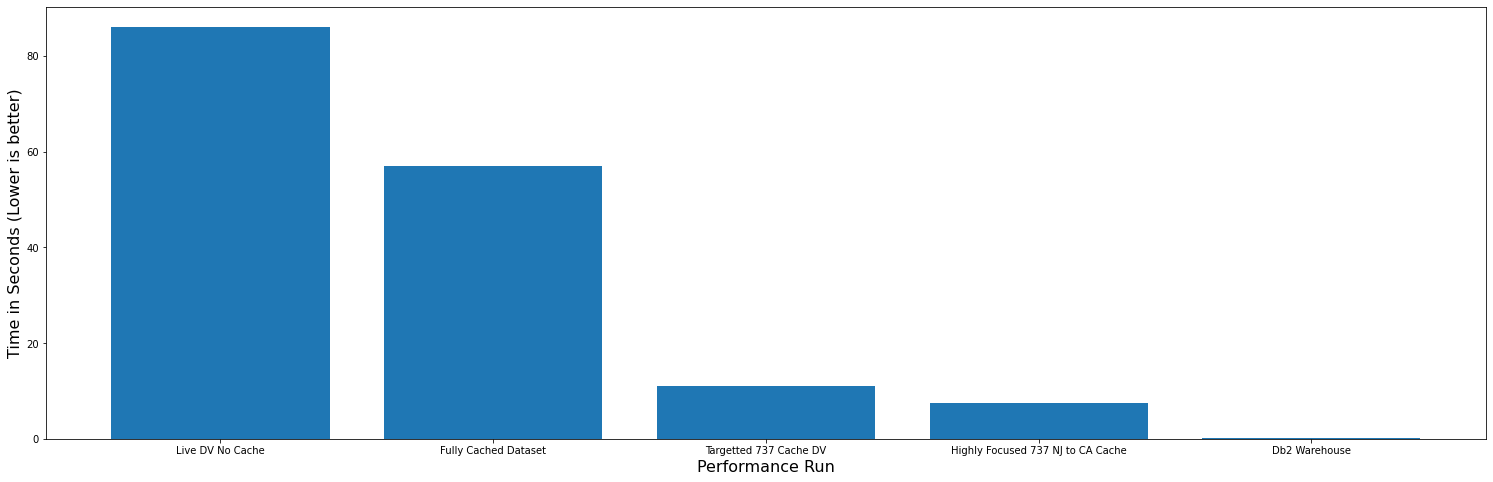

In [46]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig = plt.figure(figsize=(20, 6))
ax = fig.add_axes([0,0,1,1])
runs = ['Live DV No Cache','Fully Cached Dataset','Targetted 737 Cache DV','Highly Focused 737 NJ to CA Cache','Db2 Warehouse']
runtime = [dvnocache, dvfullcache, dv737cache, dv737njcacache, db2w]
ax.bar(runs, runtime)
plt.ylabel("Time in Seconds (Lower is better)", fontsize=16)
plt.xlabel("Performance Run", fontsize=16)
plt.show()

As a reminder, lets also look at the sizes of each of the different data sources. Run the next two cells to see how much less data we need to process when using the targetted caches. Also remember that Db2 Warehouse was able to achieve its results on the full dataset. But it requires the upfront cost of loading all the date into the Warehouse. 

In [47]:
print('Aircraft:' + str(aircraft))
print('Number of Domestic Flights in the US')
print('Years 2009 to 2010: ' + str(ontime0910))
print('Years 2011 to 2015: ' + str(ontime1115))
print('Years 2009 to 2015: ' + str(ontimefull))
print('Only 737 from 2009 to 2015: ' + str(ontime737))
print('Only 737 from NJ to CA: ' + str(ontimenjca737))

Aircraft:13101.0
Number of Domestic Flights in the US
Years 2009 to 2010: 12752436.0
Years 2011 to 2015: 30190408.0
Years 2009 to 2015: 42942844.0
Only 737 from 2009 to 2015: 4172450.0
Only 737 from NJ to CA: 37621.0


<Figure size 432x288 with 0 Axes>

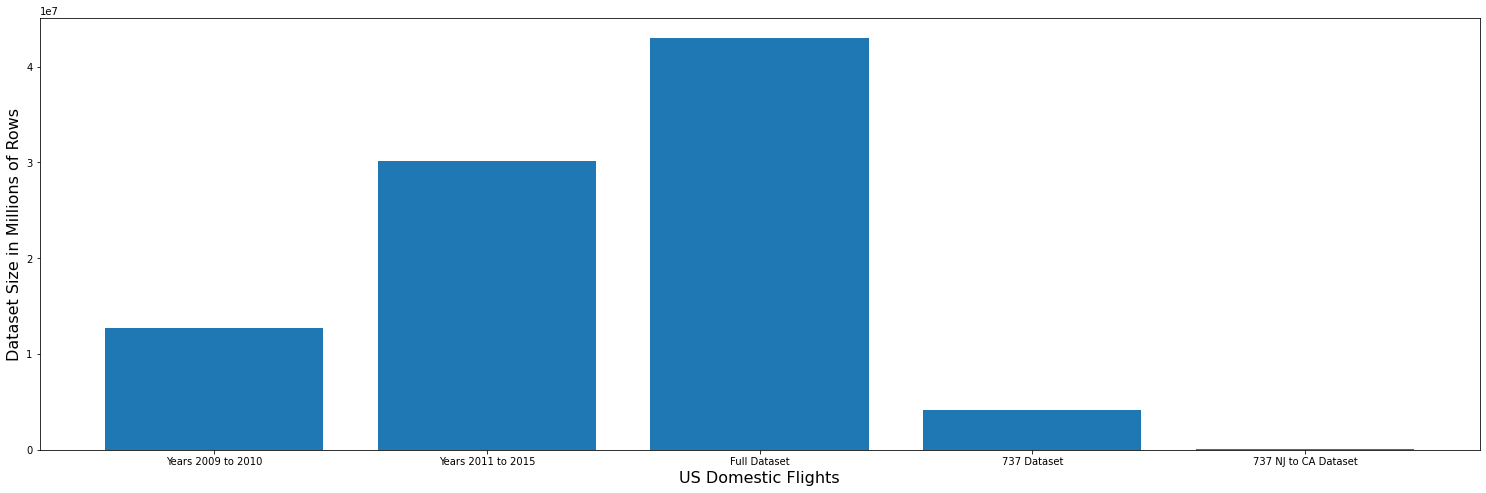

In [48]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig = plt.figure(figsize=(20, 6))
ax = fig.add_axes([0,0,1,1])
runs = ['Years 2009 to 2010','Years 2011 to 2015','Full Dataset','737 Dataset','737 NJ to CA Dataset']
runtime = [ontime0910, ontime1115, ontimefull, ontime737, ontimenjca737]
ax.bar(runs, runtime)
plt.ylabel("Dataset Size in Millions of Rows", fontsize=16)
plt.xlabel("US Domestic Flights", fontsize=16)
plt.show()

## Refreshing a Cache Through a RESTful Service Call
As you have seen throught this lab, everything you can do through the Caching management interface you can also do through REST service call from Python. There are a couple of other operations available throught REST that we can review. Run the next to cells to see how to refresh the data in a cache on demand. 

In [49]:
databaseAPI.refreshCache('DV20211115221309388288')
df = databaseAPI.getCaches("Refreshing")
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

Cache: DV20211115221309388288 being refreshed. Check cache status.


,id,name,state,size,cardinality,last_refresh_timestamp
7,DV20211115221309388288,AIRCRAFT,Refreshing,106,13101,2021-12-03 16:36:36.670765


In [50]:
df = databaseAPI.getCaches("Available")
display(df[['id', 'name','state','size', 'cardinality','last_refresh_timestamp']])

,id,name,state,size,cardinality,last_refresh_timestamp
0,DV202111161222469697,ONTIME0915,Disabled,1309298,30238851,2021-11-16 12:59:22.006647
1,DV20211110165634403313,BOEING737,Enabled,56967,4172450,2021-11-10 18:30:21.411623
2,DV20211115151427714635,ONTIME737NJCA,Enabled,554,37621,2021-11-15 15:33:30.254003
6,DV20211110144113849337,ONTIME0910,Enabled,591398,12752436,2021-11-10 16:32:41.327378
7,DV20211115221309388288,AIRCRAFT,Refreshing,106,13101,2021-12-03 16:36:36.670765
10,DV20211110144049703423,ONTIME1115,Enabled,1399806,30190408,2021-11-10 15:01:13.967413


## Get Cache Details
You can also retrieve details of each cache into a DataFrame, then format the results in almost anyway. 

In [51]:
json = databaseAPI.getCacheDetails('DV20211115221309388288')
print(json)

{'name': 'AIRCRAFT', 'id': 'DV20211115221309388288', 'query': 'SELECT * FROM ONTIME.AIRCRAFT', 'owner_id': 'ADMIN', 'type': 'U', 'created_timestamp': '2021-11-15 22:13:09.387651', 'last_modified_timestamp': '2021-12-08 17:46:08.185112', 'last_refresh_timestamp': '2021-12-03 16:36:36.670765', 'last_used_timestamp': '2021-12-03 16:58:05.092', 'state': 'Refreshing', 'size': 106, 'cardinality': 13101, 'time_taken_for_refresh': 17913, 'refresh_count': 1, 'hit_count': 44, 'refresh_schedule': '', 'refresh_schedule_desc': '', 'status_msg': ''}


In [52]:
print(json['state'])

Refreshing


In [53]:
display(pd.DataFrame(json_normalize(json))[['name','state']])

,name,state
0,AIRCRAFT,Refreshing


In this last example you can see the details of a single cache formatted in a single two column table instead of a long row by transposing the DataFrame. 

In [54]:
pd.set_option('display.max_rows', 20)
display(pd.DataFrame(json_normalize(json)).T)

,0
name,AIRCRAFT
id,DV20211115221309388288
query,SELECT * FROM ONTIME.AIRCRAFT
owner_id,ADMIN
type,U
created_timestamp,2021-11-15 22:13:09.387651
last_modified_timestamp,2021-12-08 17:46:08.185112
last_refresh_timestamp,2021-12-03 16:36:36.670765
last_used_timestamp,2021-12-03 16:58:05.092
state,Refreshing


### Next Steps
Go back and experiment with the caches and SQL statements. Change the SQL statements to see how the caches are reused for a variety of queries even if they are different from the queries that we first name. There are additional tables in the ONTIME dataset included in the virtualized data. Try creating new statement that join data with those additonal tables. Try creating your own caches. 

You may have also noticed the Spark SQL notebook in the AIRLINE Ontime project. Try out this notebook if you want to compare Data Virtualization and Db2 Warehouse performance with Spark SQL running in Waston Studio on Cloud Pak for Data.  

**Credits: IBM 2021, Peter Kohlmann [kohlmann@ca.ibm.com]**